# Modifying Metadata

In this example we will show how to modify the metadata of a SDFITS file using `dysh`.

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/metadata_management.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/metadata_management.ipynb" download>here</a> and selecting "Save Link As".

## Background

We will use a practical example. For observations with the GBT it is recommended to observe a flux density calibrator (see e.g., [Perley & Butler 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..230....7P/abstract) for a list of calibrator sources and their flux densities) with the same configuration as that used for the science observations. The reason being that the values of the temperature equivalent power of the noise diodes stored in the SDFITS files can be out of date.

In this example we won't use observations of a flux density calibrator, but instead we will use the analysis of [Goddy et al (2020)](https://ui.adsabs.harvard.edu/abs/2020RNAAS...4....3G/abstract). They find that the temperature stored in the SDFITS files is on average lower than the measured values, so that the temperature must be corrected by 20%
$$
T_{\rm{CAL,corr}}=1.2T_{\rm{CAL,file}}.
$$
Here we use this to correct the temperature of the noise diode.

## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for working with the data.
from dysh.fits.gbtfitsload import GBTFITSLoad

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

### Data retrieval

We download the data we will use for this example, if necessary.

In [2]:
url = "https://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

### Data loading

We load the data and inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)

In [4]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.642740
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


### Metadata inspection

Now we inspect the current noise diode temperature stored in the SDFITS file.

In [5]:
sdfits["TCAL", "PLNUM"]

,TCAL,PLNUM
0,1.424292,1
1,1.424292,1
2,1.452650,0
3,1.452650,0
4,1.424292,1
...,...,...
347,1.452650,0
348,1.424292,1
349,1.424292,1
350,1.452650,0


For polarization 0 the noise diode temperature is 1.452650 K and for polarization 1 it is 1.424292 K.

We will calibrate the data using these values to compare after we update the noise diode temperature. We use position switching calibration, then we time average all the scans and remove an order 1 polynomial.

In [6]:
ps_original = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
ps_original.baseline(degree=1, remove=True)

### Metadata update

Now we update the temperature of the noise diode by multiplying by 1.2.

In [7]:
sdfits["TCAL"] *= 1.2

update column succeeded for TCAL


/home/scratch/psalas/python/dysh/src/dysh/fits/gbtfitsload.py:2540: UserWarning: Changing an existing SDFITS column TCAL
  warnings.warn(f"Changing an existing SDFITS column {items}")  # noqa: B028
/home/scratch/psalas/python/dysh/src/dysh/fits/sdfitsload.py:1108: UserWarning: Changing an existing SDFITS column TCAL
  warnings.warn(f"Changing an existing SDFITS column {items}")  # noqa: B028


Now we check that the values were updated.

In [8]:
sdfits["TCAL", "PLNUM"]

,TCAL,PLNUM
0,1.70915,1
1,1.70915,1
2,1.74318,0
3,1.74318,0
4,1.70915,1
...,...,...
347,1.74318,0
348,1.70915,1
349,1.70915,1
350,1.74318,0


The values were updated. We proceed with the data reduction.

In [9]:
ps_updated = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
ps_updated.baseline(degree=1, remove=True)

Now plot and compare the result. Since the antenna temperature is directly proportional to the temperature of the noise diode, now the line profile after the update should be 20% brighter than without the update.

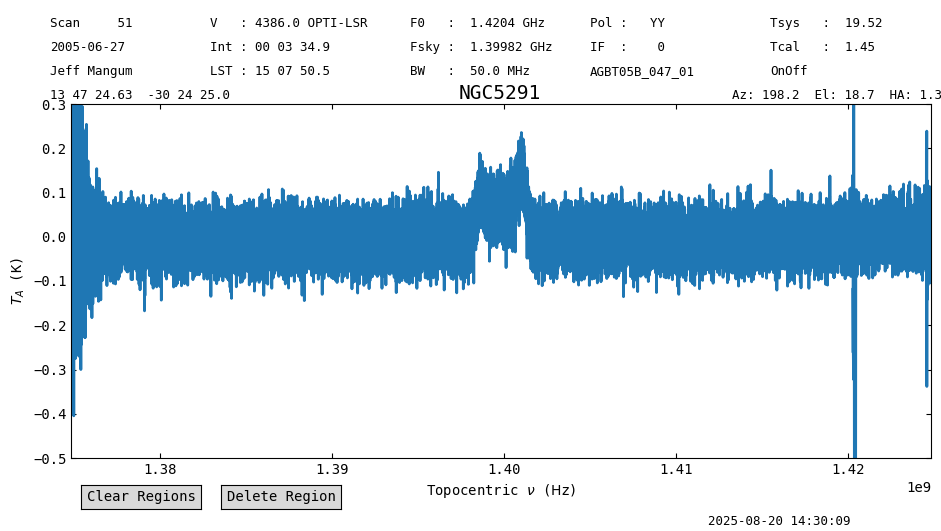

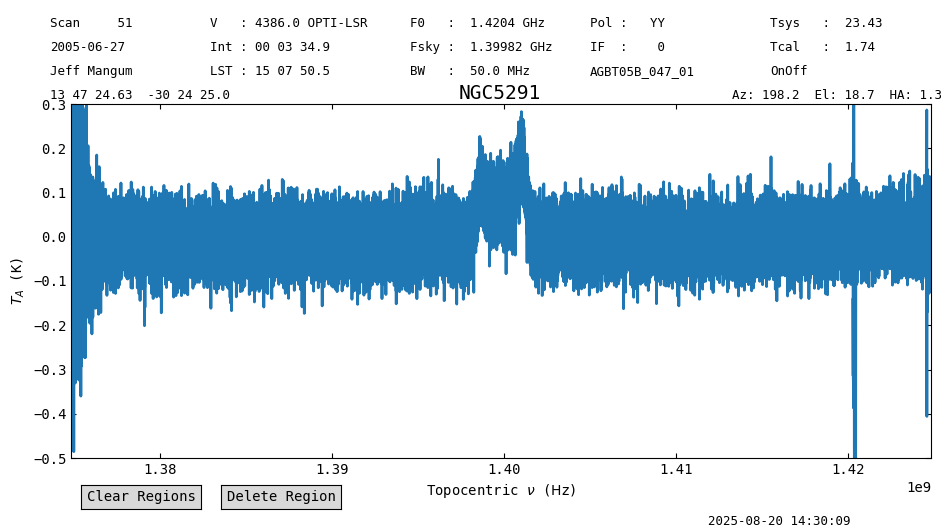

In [10]:
ps_original.plot(ymin=-0.5, ymax=0.3)
ps_updated.plot(ymin=-0.5, ymax=0.3)